Con el objetivo de identificar el modelo que mejor prediga al ganador de un combate, decidimos probar diversas técnicas de análisis.

En este proceso, observamos que un experto en el área no necesariamente se enfocaría en las estadísticas de cada peleador de manera individual. En lugar de eso, podría ser más útil analizar la diferencia entre las estadísticas de los dos peleadores. Es decir, en lugar de considerar los datos de cada peleador por separado, se podría prestar más atención a cómo varían esas estadísticas de un peleador a otro.

Por esta razón, calculamos la diferencia en las estadísticas entre los peleadores y luego probamos varios modelos de predicción para ver si este enfoque ofrecía mejores resultados que trabajar solo con las estadísticas individuales de cada luchador.

Moficaciones:
Andrés: He cambiado el codigo para que los modelos usaen la GPU para entrenar *Mateo: Ya vi que se podía hacer pero tarda más

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

In [3]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..", "..","data", "P2_dif","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2010-01-02,Rashad Evans,Thiago Silva,False,-0.3,-0.239,0.230769,-0.2,0.0,1.2,...,17.3,4.0,4.223836,0.5,-0.7,0.0,4.0,-0.3,0.0,1.0
1,2010-01-02,Sam Stout,Joe Lauzon,False,0.5,-0.252,-0.331250,-3.0,0.0,-104.6,...,-2.0,1.0,-2.396327,-0.9,-1.8,-2.5,2.5,-1.0,1.0,2.8
2,2010-01-11,Rafael Dos Anjos,Kyle Bradley,False,0.0,-0.114,-0.082353,1.3,0.3,187.2,...,0.0,0.0,0.000000,0.0,-0.5,0.0,0.5,-0.8,0.0,0.8
3,2010-01-11,Amir Sadollah,Brad Blackburn,False,-1.1,0.048,0.000000,-0.1,0.0,110.6,...,-3.0,0.0,-0.546865,-1.0,-1.0,1.0,-0.8,0.8,0.0,0.0
4,2010-01-11,Gray Maynard,Nate Diaz,False,0.0,0.062,0.142089,-1.3,-0.6,158.4,...,-2.4,-1.0,-0.943809,3.3,1.0,-4.5,3.3,0.0,0.0,-1.8


In [4]:
ruta_val = os.path.join("..","..", "..","data", "P2_dif","validation.parquet")
df_val = pd.read_parquet(ruta_val)
df_val.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2021-10-30,Magomed Ankalaev,Volkan Oezdemir,False,0.2,0.074,0.272727,0.0,0.0,157.9,...,0.0,-2.0,62.537106,3.0,0.8,0.0,-0.3,-1.5,0.0,-1.0
1,2021-10-30,Jan Blachowicz,Glover Teixeira,True,0.2,-0.173,0.031746,-1.4,-0.4,-253.0,...,-23.3,-4.0,92.929969,0.0,-2.0,-3.5,1.5,-1.0,0.0,1.0
2,2021-10-30,Alexander Volkov,Marcin Tybura,False,0.3,0.088,-0.263158,0.0,0.0,-128.4,...,10.0,-4.0,9.933111,-2.0,0.5,0.0,-2.0,-2.0,0.0,-0.5
3,2021-10-30,Makwan Amirkhani,Lerone Murphy,True,0.0,-0.090,0.257778,-0.2,-0.2,78.4,...,3.0,7.0,8.305570,-1.0,0.2,3.0,0.5,1.0,0.0,2.3
4,2021-10-30,Amanda Ribas,Virna Jandiroba,False,0.0,-0.015,0.083333,-0.2,0.2,128.1,...,-7.0,0.0,37.406009,2.5,-0.5,-0.2,2.0,0.5,0.0,-1.8


In [5]:
ruta_test = os.path.join("..","..", "..","data", "P2_dif","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2023-06-17,Nicolas Dalby,Muslim Salikhov,False,-0.2,-0.049,-0.163685,0.3,0.3,76.4,...,0.4,2.0,-92.867755,-1.6,-2.5,0.0,1.3,-0.8,-1.0,4.0
1,2023-06-24,Randy Brown,Wellington Turman,False,0.3,-0.213,-0.173077,-0.8,0.3,-111.7,...,-1.0,8.0,108.879508,2.0,2.0,2.2,2.8,0.0,1.5,-0.5
2,2023-06-24,Josh Emmett,Ilia Topuria,True,-0.6,-0.133,-0.017316,-0.5,0.2,-2.2,...,4.0,7.0,46.125005,1.0,0.2,-0.5,4.8,1.0,0.5,1.0
3,2023-06-24,Neil Magny,Phil Rowe,False,-0.5,-0.028,0.233871,-0.7,0.0,28.6,...,11.4,25.0,87.742466,-0.4,2.7,1.8,13.0,2.0,4.5,1.0
4,2023-06-24,Amanda Ribas,Maycee Barber,True,0.0,-0.100,0.008929,0.2,-0.7,205.2,...,-1.0,-1.0,-31.227306,-2.0,-3.0,2.0,0.2,1.0,0.0,-1.2


In [6]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.565996
True     0.434004
Name: proportion, dtype: float64

In [7]:
X_val = df_val.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_val = df_val["WINNER"]
y_val.value_counts(normalize=True)

WINNER
False    0.541841
True     0.458159
Name: proportion, dtype: float64

In [8]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.55
True     0.45
Name: proportion, dtype: float64

#### MODELO BASELINE

Creo un modelo simple el cual debería conseguir mejorar tras realizar los ajustes de hiperparámetros. Para este modelo usaré los hiperparámetros por defecto de XGBoost, sin tener en cuenta los ligeros desbalances de clase ni eliminando atributos no útiles.

In [9]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_val)
y_val_prob = base.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5188284518828452
F1-Score: 0.4162
AUC-ROC: 0.5137
Precisión: 0.4686
Sensibilidad: 0.3744
Log-loss: 0.9056848667112173


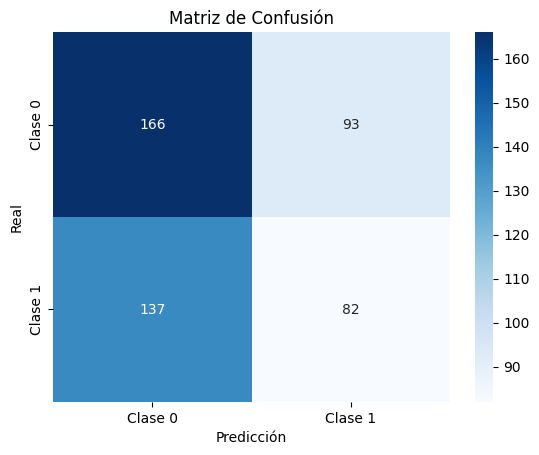

In [11]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

En nuestro caso eliminamos algunas variables que no aportaban información al modelo para reducir el coste computacional.

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

Como podemos ver en nuestro modelo baseline hay problemas notables respecto a las predicciones de la Clase-1, intentaremos conseguir un mejor modelo usando las técnicas de ajuste de hiperparámetros

In [12]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [1, 3],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_

In [ ]:
# print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
# best_grid = train_xgboost_grid(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


KeyboardInterrupt: 

In [ ]:
# print("-- Métricas del modelo con hiperparámetros ajustados --")
# y_val_pred = best_grid.predict(X_val)
# y_val_prob = best_grid.predict_proba(X_val)[:,1]
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# f1_val = f1_score(y_val, y_val_pred)
# roc_auc_val = roc_auc_score(y_val, y_val_prob)
# precision_val = precision_score(y_val, y_val_pred)
# recall_val = recall_score(y_val, y_val_pred)
# log_loss_val = log_loss(y_val,y_val_prob)
# print(f"F1-Score: {f1_val:.4f}")
# print(f"AUC-ROC: {roc_auc_val:.4f}")
# print(f"Precisión: {precision_val:.4f}")
# print(f"Sensibilidad: {recall_val:.4f}")
# print(f"Log-loss: {log_loss_val}")

In [ ]:
# # Calcular la matriz de confusión
# cm = confusion_matrix(y_val, y_val_pred)

# # Visualizar la matriz de confusión
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
# plt.xlabel('Predicción')
# plt.ylabel('Real')
# plt.title('Matriz de Confusión')
# plt.show()

In [ ]:
# feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': best_grid.feature_importances_
# }).sort_values(by='Importance', ascending=False)
# print(feature_importance)

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
# plt.xlabel("Permutation Importance")
# plt.title("Feature Importance (Top 10)")
# plt.yticks(fontsize=5)
# plt.grid(axis="x", linestyle="--", alpha=0.7)
# plt.show()

In [ ]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 30, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return random_search

In [ ]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
resultados_random = train_xgboost_random(X_train,y_train,X_val,y_val)
best_random = resultados_random.best_estimator_
results_cv = resultados_random.cv_results_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'subsample': np.float64(1.0), 'scale_pos_weight': np.float64(1.304123711340206), 'n_estimators': np.int64(50), 'min_child_weight': np.int64(5), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.1577777777777778), 'gamma': np.float64(0.2), 'colsample_bytree': np.float64(0.7)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.61      0.53      0.57       259
        True       0.52      0.59      0.55       219

    accuracy                           0.56       478
   macro avg       0.56      0.56      0.56       478
weighted avg       0.56      0.56      0.56       478



c:\Users\andre\OneDrive - Universidad Complutense de Madrid (UCM)\Escritorio\UNIVERSIDAD\2º\2º Cuatrimestre\PD1\c2425-R4\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\andre\OneDrive - Universidad Complutense de Madrid (UCM)\Escritorio\UNIVERSIDAD\2º\2º Cuatrimestre\PD1\c2425-R4\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\andre\OneDrive - Universidad Complutense

In [ ]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_val)
y_val_prob = best_random.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5585774058577406
F1-Score: 0.5501
AUC-ROC: 0.5784
Precisión: 0.5160
Sensibilidad: 0.5890
Log-loss: 0.6944439095995641
[[138 121]
 [ 90 129]]


In [ ]:
df_cv_results = pd.DataFrame(results_cv)
df_cv_results = df_cv_results.sort_values(by="rank_test_score")
df_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.101598,0.029488,0.023146,0.005145,1.0,1.304124,50,5,3,0.157778,...,0.7,"{'subsample': 1.0, 'scale_pos_weight': 1.30412...",0.520673,0.543363,0.573740,0.577441,0.517938,0.546631,0.025266,1
49,0.399786,0.126176,0.032254,0.011920,1.0,1.304124,150,7,6,0.136667,...,0.7,"{'subsample': 1.0, 'scale_pos_weight': 1.30412...",0.488190,0.566703,0.549865,0.577113,0.508615,0.538097,0.034173,2
21,1.031453,0.419569,0.027628,0.004215,1.0,1.304124,150,1,12,0.157778,...,0.5,"{'subsample': 1.0, 'scale_pos_weight': 1.30412...",0.502501,0.536174,0.555914,0.549720,0.537691,0.536400,0.018488,3
9,1.696690,0.748385,0.038795,0.004691,0.9,1.304124,250,9,15,0.010000,...,1.0,"{'subsample': 0.9, 'scale_pos_weight': 1.30412...",0.536475,0.547168,0.552036,0.525368,0.518871,0.535984,0.012558,4
44,0.953970,0.404869,0.033332,0.005974,0.9,1.304124,300,3,21,0.200000,...,0.7,"{'subsample': 0.9, 'scale_pos_weight': 1.30412...",0.511674,0.536708,0.546539,0.552885,0.522607,0.534083,0.015162,5


In [ ]:
def plot_feature_importances(model, X_val, y_val, feature_names):
    # Calcular la importancia de permutación
    perm_importance = permutation_importance(model, X_val, y_val, scoring="f1_macro", n_repeats=10, random_state=42, n_jobs=-1)
    
    # Ordenar características por importancia
    sorted_idx = np.argsort(perm_importance.importances_mean)[-10:] # Tomar el top 10

    # Graficar las importancias
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx], 
             xerr=perm_importance.importances_std[sorted_idx], color="royalblue")
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance (Top 10)")
    plt.yticks(fontsize=10)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
23  Victorias_Decision_DIFF    0.083155
20               Racha_DIFF    0.066971
18              Peleas_DIFF    0.048847
14        STR_GROUND_A_DIFF    0.046827
1              SIG_STR_DIFF    0.044954
13        STR_CLINCH_A_DIFF    0.042201
7          TOTAL_STR_A_DIFF    0.041716
9           STR_HEAD_A_DIFF    0.041297
24         Derrotas_KO_DIFF    0.040680
19              Puntos_DIFF    0.037481
5                 CTRL_DIFF    0.036364
3              SUB_ATT_DIFF    0.036159
12      STR_DISTANCE_A_DIFF    0.035623
6              TD_PORC_DIFF    0.033953
21        Victorias_KO_DIFF    0.033683
11           STR_LEG_A_DIFF    0.033632
8                 TD_A_DIFF    0.033484
4                  REV_DIFF    0.033414
2                   TD_DIFF    0.032821
10          STR_BODY_A_DIFF    0.031666
26   Derrotas_Decision_DIFF    0.030661
16            GRAPPLER_DIFF    0.030518
25        Derrotas_Sub_DIFF    0.028199
17              Record_DIFF    0.028018


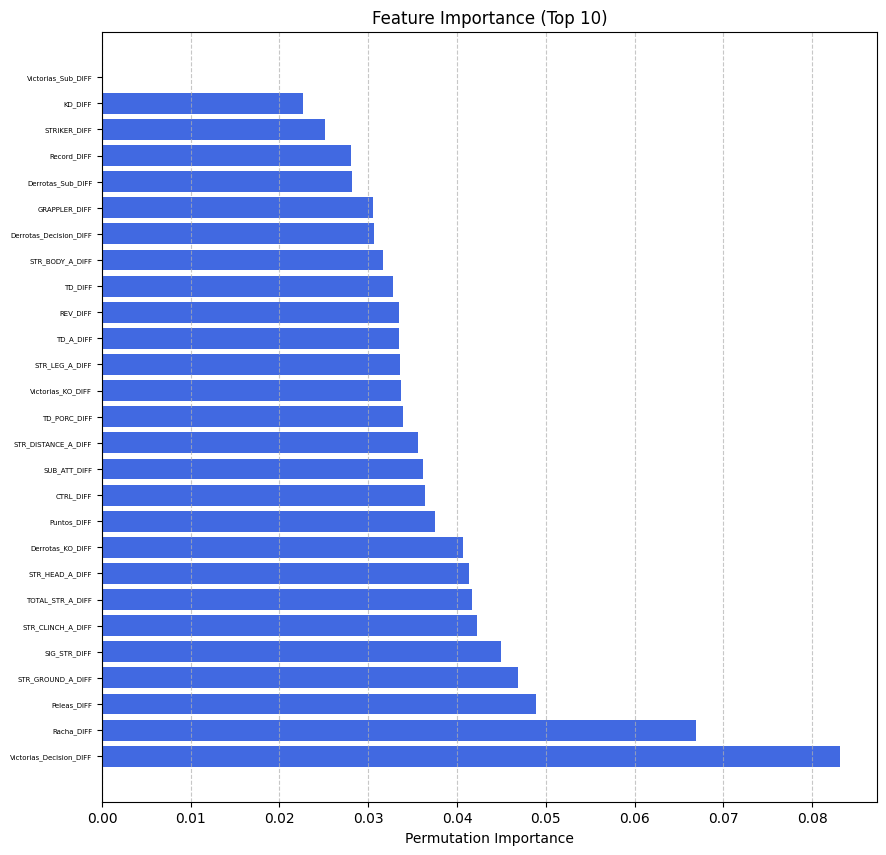

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Como podemos observar, las variables que se consideran más relevantes no están directamente relacionadas con las características del combate en sí, sino que se enfocan más en otros aspectos, como el número de victorias por decisión, la racha de victorias, y el número total de peleas de cada peleador. Esto nos lleva a la conclusión de que, en lugar de centrarnos únicamente en las estadísticas de los combates de cada luchador, habría sido más interesante y útil obtener información sobre contra quién ha peleado cada peleador.

El análisis de los rivales a los que se ha enfrentado cada luchador podría proporcionar una perspectiva más valiosa sobre su desempeño y capacidad, ya que enfrentarse a oponentes más fuertes o con habilidades diferentes podría tener un gran impacto en el resultado de los combates. Por lo tanto, obtener datos sobre la calidad y el nivel de los rivales sería probablemente más relevante que simplemente analizar las estadísticas de las peleas pasadas.

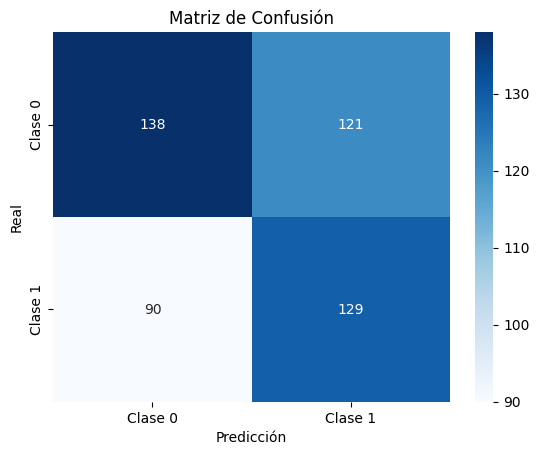

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()